In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
import time 
from ymaeda_tools.dft import dft, idft, timeshift_cplx, halfdft_timeshift, exidft_timeshift
from ymaeda_tools.read_dGM import read_dseq1, read_dimseq2, readall_dobs

# time step used by YMAEDA_TOOLS
dt = 0.1 
# frequency step size used by YMAEDA_TOOLS
df = 0.002441406 
# frequency half space used by YMAEDA_TOOLS
f = np.arange(0, df * 2049, df) 
# frequency full space used by YMAEDA_TOOLS
F = np.arange(0, df * 4096, df) 

# base directories
base_dir = "/Volumes/MAC Backup/Final Year Projects/Shinmoedake Data/kirishima_invert/"
parent_dir = "inversion_results_dump_new/inversion_result_residuals117/t60_p100/x-10900y-121100z1000/"

# target directory
target_dir = "inv_data_dir_supershort_filtered/"

# wanted station
station = "EV.SMN"

In [2]:
def seq1_check(directory_name):
    if "contribution" in directory_name or "green" in directory_name:
        E_suffix = ".E.sac.M.seq1"
        N_suffix = ".N.sac.M.seq1"
        U_suffix = ".U.sac.M.seq1"
    else:
        E_suffix = ".E.sac.seq1"
        N_suffix = ".N.sac.seq1"
        U_suffix = ".U.sac.seq1"
        
    directory_name = base_dir + parent_dir + directory_name + target_dir
    
    E = read_dseq1(directory_name, station + E_suffix)
    N = read_dseq1(directory_name, station + N_suffix)
    U = read_dseq1(directory_name, station + U_suffix)
    
    t = np.arange(0, len(E) * dt, dt)
    return t, E, N, U
    
def imseq2_check(directory_name):
    if "contribution" in directory_name or "green" in directory_name:
        E_suffix = '.E.sac.M.imseq2'
        N_suffix = '.N.sac.M.imseq2'
        U_suffix = '.U.sac.M.imseq2'
    else:
        E_suffix = '.E.sac.imseq2'
        N_suffix = '.N.sac.imseq2'
        U_suffix = '.U.sac.imseq2'
        
    directory_name = base_dir + parent_dir + directory_name + target_dir
    
    f_E, C_E = read_dimseq2(directory_name, station + E_suffix)
    f_N, C_N = read_dimseq2(directory_name, station + N_suffix)
    f_U, C_U = read_dimseq2(directory_name, station + U_suffix)
    return f_U, C_E, C_N, C_U

(61,) (61,) (61,) (61,)
(4096,) (4096,) (4096,) (4096,)


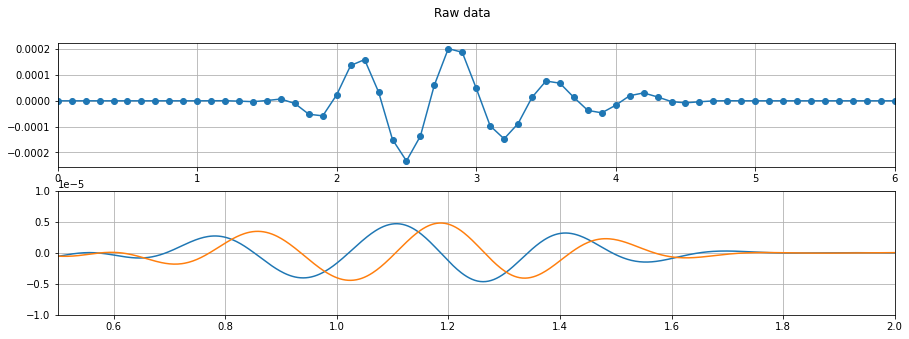

In [3]:
# Raw measured seismograms .seq1 files...
raw_dat_dir = \
"inversion_results_dump_new/inversion_result_residuals117/data_obs/inv_data_dir_supershort_filtered/"
raw_E = read_dseq1(base_dir + raw_dat_dir, "EV.SMN.E.sac.seq1")
raw_N = read_dseq1(base_dir + raw_dat_dir, "EV.SMN.N.sac.seq1")
raw_U = read_dseq1(base_dir + raw_dat_dir, "EV.SMN.U.sac.seq1")
raw_t = np.arange(0, len(raw_E)*dt, dt)

# Raw measured seismograms spectrum .imseq2 files...
raw_dat_dir = \
"inversion_results_dump_new/inversion_result_residuals117/data_obs_spectrum/inv_data_dir_supershort_filtered/"
f_raw_E_spec, raw_E_spec = read_dimseq2(base_dir + raw_dat_dir, "EV.SMN.E.sac.imseq2")
f_raw_N_spec,raw_N_spec = read_dimseq2(base_dir + raw_dat_dir, "EV.SMN.N.sac.imseq2")
f_raw_U_spec, raw_U_spec = read_dimseq2(base_dir + raw_dat_dir, "EV.SMN.U.sac.imseq2")

print(raw_t.shape, raw_E.shape, raw_N.shape, raw_U.shape)
print(np.shape(f_raw_E_spec), np.shape(raw_E_spec), np.shape(raw_N_spec), np.shape(raw_U_spec))

plt.figure(figsize = (15, 5))
plt.suptitle("Raw data")
plt.subplot(2, 1, 1)
plt.plot(raw_t, raw_U, "-o")
plt.xlim([0, 6])
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(f_raw_U_spec, np.real(raw_U_spec))
plt.plot(f_raw_U_spec, np.imag(raw_U_spec))
plt.grid(True)
plt.xlim([0.5, 2.0])
plt.ylim(-1e-5, 1e-5)
plt.show()

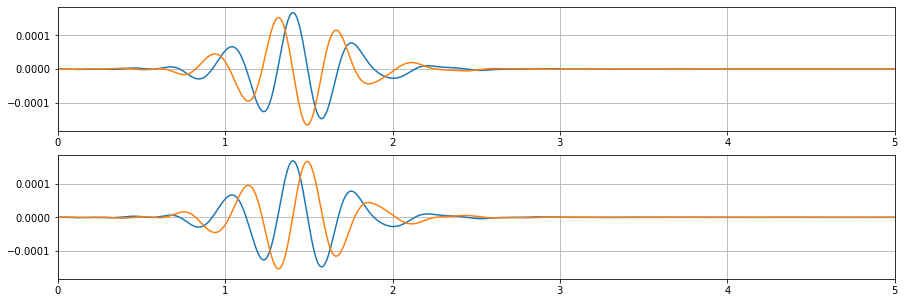

In [39]:
# Also, note the difference between "normal" DFT and YMAEDA_TOOLS DFT.
# While the real portion is the same, the imaginary portion is not!

CU = fft(np.hstack([raw_U, np.zeros(4096-len(raw_U))])) * dt # scipy FFT
CU1 = dft(np.hstack([raw_U, np.zeros(4096-len(raw_U))])) * dt # YMAEDA_TOOLS compliant DFT

plt.figure(figsize = (15, 5))
plt.subplot(2,1,1)
plt.plot(f_raw_U_spec, np.real(CU), f_raw_U_spec, np.imag(CU))
plt.xlim([0, 5])
plt.grid(True)
plt.subplot(2,1,2)
plt.plot(f_raw_U_spec, np.real(CU1), f_raw_U_spec, np.imag(CU1))
plt.xlim([0, 5])
plt.grid(True)
plt.show()

(4096,) (4096,) (4096,) (4096,)
(4096,) (4096,) (4096,) (4096,)


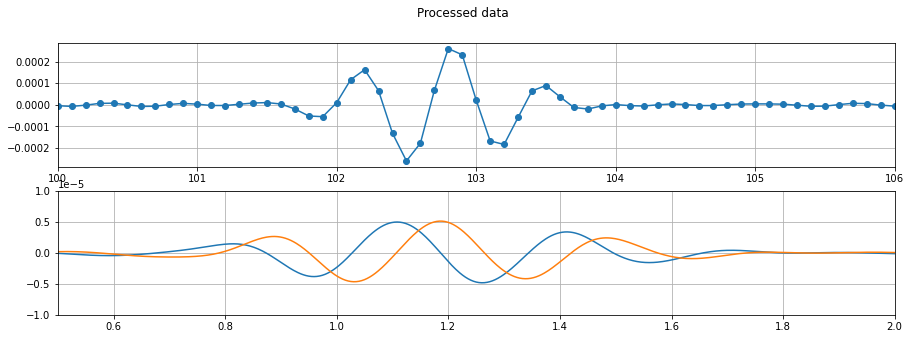

In [37]:
# YMAEDA_TOOLS data_syn processed seismograms and spectra
# This waveform and spectrum are not the original observed seismograms, but have been processed for inversion.
t, E, N, U = seq1_check("data_syn/")
f_U, C_E, C_N, C_U = imseq2_check("data_syn_spectrum/")

print(t.shape, E.shape, N.shape, U.shape)
print(f_U.shape, C_E.shape, C_N.shape, C_U.shape)

plt.figure(figsize = (15, 5))
plt.suptitle("Processed data")
plt.subplot(2,1,1)
plt.xlim([100, 106])
plt.plot(t, U, "-o")
plt.grid(True)
plt.subplot(2,1,2)
plt.plot(f_U, np.real(C_U), f_U, np.imag(C_U))
plt.xlim([0.5, 2.0])
plt.ylim(-1e-5, 1e-5)
plt.grid(True)
plt.show()

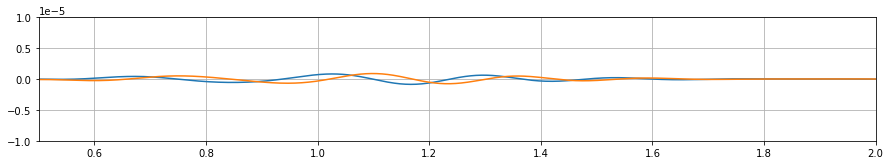

In [35]:
# Load the 2049 dX.cv files in d_obs/
d_obs = readall_dobs(base_dir + parent_dir)
d_obs = np.transpose(np.vstack([np.real(d_obs), np.imag(d_obs)]))

plt.figure(figsize = (15, 5))
plt.subplot(2, 1, 1)
plt.plot(f, d_obs[:, 0])
plt.plot(f, d_obs[:, 1])
plt.xlim([0.5, 2.0])
plt.ylim(-1e-5, 1e-5)
plt.grid(True)
plt.show()